i: 0 j: 0 nb: 205 cost: 0.694756833901 error rate: 0.6
i: 0 j: 10 nb: 205 cost: 0.689069872441 error rate: 0.4
i: 0 j: 20 nb: 205 cost: 0.694234093832 error rate: 0.55
i: 0 j: 30 nb: 205 cost: 0.690054133271 error rate: 0.55
i: 0 j: 40 nb: 205 cost: 0.689134851998 error rate: 0.4
i: 0 j: 50 nb: 205 cost: 0.690924607527 error rate: 0.55
i: 0 j: 60 nb: 205 cost: 0.707140653069 error rate: 0.75
i: 0 j: 70 nb: 205 cost: 0.698924003728 error rate: 0.6
i: 0 j: 80 nb: 205 cost: 0.69462799473 error rate: 0.5
i: 0 j: 90 nb: 205 cost: 0.686461989327 error rate: 0.3
i: 0 j: 100 nb: 205 cost: 0.691283592887 error rate: 0.5
i: 0 j: 110 nb: 205 cost: 0.692328454999 error rate: 0.45
i: 0 j: 120 nb: 205 cost: 0.697096410545 error rate: 0.55
i: 0 j: 130 nb: 205 cost: 0.691772457907 error rate: 0.35
i: 0 j: 140 nb: 205 cost: 0.69364895921 error rate: 0.55
i: 0 j: 150 nb: 205 cost: 0.691821071405 error rate: 0.5
i: 0 j: 160 nb: 205 cost: 0.695436491963 error rate: 0.6
i: 0 j: 170 nb: 205 cost: 0.69251352

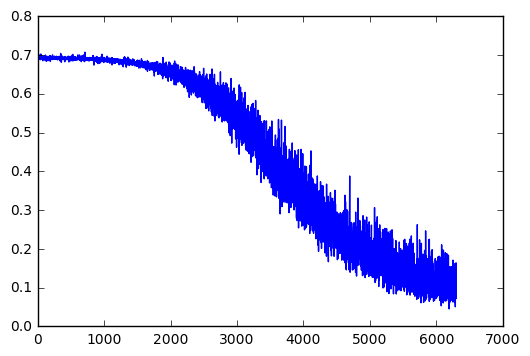

In [1]:
# https://deeplearningcourses.com/c/deep-learning-recurrent-neural-networks-in-python
# https://udemy.com/deep-learning-recurrent-neural-networks-in-python
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

from util import init_weight, all_parity_pairs
from sklearn.utils import shuffle


class HiddenLayer(object):
    def __init__(self, M1, M2, an_id):
        self.id = an_id
        self.M1 = M1
        self.M2 = M2
        W = init_weight(M1, M2)
        b = np.zeros(M2)
        self.W = theano.shared(W, 'W_%s' % self.id)
        self.b = theano.shared(b, 'b_%s' % self.id)
        self.params = [self.W, self.b]

    def forward(self, X):
        return T.nnet.relu(X.dot(self.W) + self.b)


class ANN(object):
    def __init__(self, hidden_layer_sizes):
        self.hidden_layer_sizes = hidden_layer_sizes

    def fit(self, X, Y, learning_rate=10e-3, mu=0.99, reg=10e-12, eps=10e-10, epochs=400, batch_sz=20, print_period=1, show_fig=False):

        # X = X.astype(np.float32)
        Y = Y.astype(np.int32)

        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        count = 0
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2, count)
            self.hidden_layers.append(h)
            M1 = M2
            count += 1
        W = init_weight(M1, K)
        b = np.zeros(K)
        self.W = theano.shared(W, 'W_logreg')
        self.b = theano.shared(b, 'b_logreg')

        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params

        # for momentum
        dparams = [theano.shared(np.zeros(p.get_value().shape)) for p in self.params]

        # for rmsprop
        cache = [theano.shared(np.zeros(p.get_value().shape)) for p in self.params]

        # set up theano functions and variables
        thX = T.matrix('X')
        thY = T.ivector('Y')
        pY = self.forward(thX)

        rcost = reg*T.sum([(p*p).sum() for p in self.params])
        cost = -T.mean(T.log(pY[T.arange(thY.shape[0]), thY])) + rcost
        prediction = self.predict(thX)
        grads = T.grad(cost, self.params)

        # momentum only
        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates,
        )

        n_batches = N / batch_sz
        # print "N:", N, "batch_sz:", batch_sz
        # print "n_batches:", n_batches
        costs = []
        for i in xrange(epochs):
            X, Y = shuffle(X, Y)
            for j in xrange(n_batches):
                Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]

                c, p = train_op(Xbatch, Ybatch)

                if j % print_period == 0:
                    costs.append(c)
                    e = np.mean(Ybatch != p)
                    print "i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e
        
        if show_fig:
            plt.plot(costs)
            plt.show()

    def forward(self, X):
        Z = X
        for h in self.hidden_layers:
            Z = h.forward(Z)
        return T.nnet.softmax(Z.dot(self.W) + self.b)

    def predict(self, X):
        pY = self.forward(X)
        return T.argmax(pY, axis=1)


def wide():
    X, Y = all_parity_pairs(12)
    model = ANN([2048])
    model.fit(X, Y, learning_rate=10e-5, print_period=10, epochs=300, show_fig=True)

def deep():
    # Challenge - find a deeper, slimmer network to solve the problem
    X, Y = all_parity_pairs(12)
    model = ANN([1024]*2)
    model.fit(X, Y, learning_rate=10e-4, print_period=10, epochs=100, show_fig=True)

if __name__ == '__main__':
    wide()
    # deep()